## Description  
Author: shuheng.mo21@imperial.ac.uk (sm321@ic.ac.uk)          

This notebook contains the parallelisation of solving advection-diffusion  using multigrid method in three-dimensional space implemented with MPI (mpi4py). The script within this notebook is converted to Python scripts and presented at [here](https://github.com/ese-msc-2021/irp-sm321/tree/main/code).          


## Hardware resource details

In [13]:
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices if available
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # avoid tf dnn flag issue
# !lsb_release -a
# !nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q

# !lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
# !free -h --si | awk  '/Mem:/{print $2}'

# TPU Configuration
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

Hardware log for last run of this notebook:

```
Thu Aug 25 19:48:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    37W / 250W |    423MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
+-----------------------------------------------------------------------------+
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
26G
```

## Prerequisites

In [534]:
# ! pip install mpi4py
! python -m pip install mpi4py

# profiling tools
! pip install line_profiler

# acceleration toolkits
# ! pip install -U cupy-cuda111 # still slow on jumping for loops
# ! pip install numba # numba not working well on multi processes
# ! pip install --upgrade taichi  # Install Taichi Lang
# ! pip install pyvista
# config the xvfb server for Ubuntu
# ! sudo apt install libgl1-mesa-glx xvfb

# folders
! mkdir serial_out
! mkdir parallel_out
! mkdir norms
# ! mkdir result_buildings
# ! mkdir result_buildings_parallel
! mkdir parallel_steps
! mkdir performance_analysis
 
# debug
# ! mkdir initial_conditions
! mkdir boundary_conditions

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
# import cupy as cp
# import taichi as ti # taichi is able to accelerate any python code (not sure if tensorflow included) if correct decorator specified 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # avoid tf dnn flag issue

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

mkdir: serial_out: File exists
mkdir: parallel_out: File exists
mkdir: norms: File exists
mkdir: parallel_steps: File exists
mkdir: performance_analysis: File exists
mkdir: boundary_conditions: File exists


## Options for GPU acceleration

In [535]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [536]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
print(is_gpu)

False


## Initial Conditions

(1, 160, 160, 128, 1)

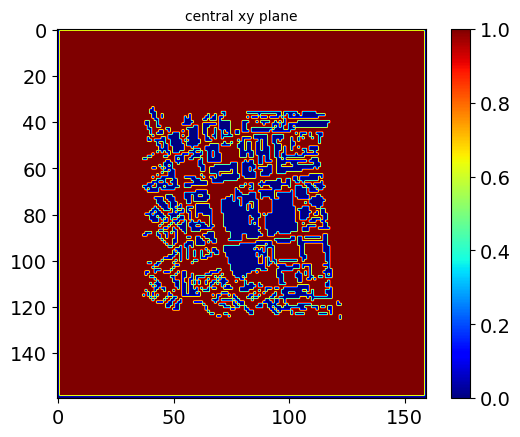

In [537]:
mesh = np.load('mesh_64_sk.npy')
plt.imshow(mesh[0,:,:,1,0], cmap='jet')
plt.colorbar()
# plt.title('central xy plane',Fontsize=20)
plt.title('central xy plane',fontsize=10)
mesh.shape

In [538]:
input_shape = (1,128,128,128,1)
sigma = np.zeros(input_shape).astype('float32')

for i in range(1,128-1):
    for j in range(1,128-1):
        for k in range(1,128-1):
            if mesh[0][i+16][j+16][k][0] == 0:
                sigma[0][k][j][i][0] = 100000

(1, 128, 128, 128, 1)

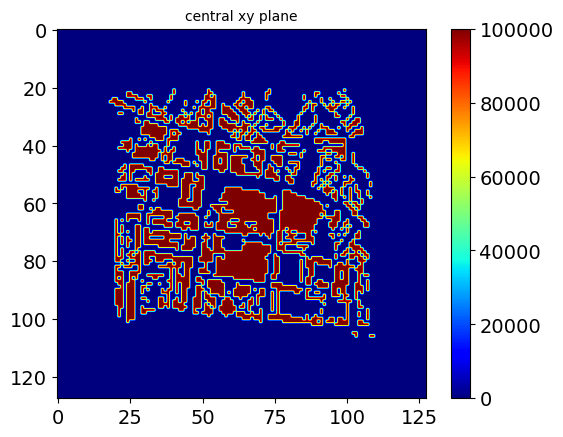

In [539]:
plt.imshow(sigma[0,1,:,:,0], cmap='jet') # look from xy plane
plt.colorbar()
plt.title('central xy plane',fontsize=10)
sigma.shape

## Fix the cudaCNN runtime issue

In [9]:
# if reports the "DNN library is not found" error, try update the cudaCNN runtime
# https://www.tensorflow.org/install/source#gpu check the cudaCNN runtime version
# !sudo apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 # tackle the cudaCNN runtime problem of Colab

## Serial implementation

In [670]:
%%writefile naiver_stokes_3D.py
# TensorFlow ≥2.0 is required
from time import perf_counter
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # avoid tf dnn flag issue


# flags and env variables
# if we want compile and run as tf.function
tf.config.run_functions_eagerly(True)

# https://cupy.dev/ # accelarate the mult-dim array on GPU
# def cupy2tensor(cp_array):
#   cap = cp_array.toDlpack()
#   return tf.experimental.dlpack.from_dlpack(cap)

# def tensor2cupy(tensor):
#   cap = tf.experimental.dlpack.to_dlpack(tensor)
#   return cp.from_dlpack(cap)

# CFD Parameters
dt = 0.1        # time step (s)
dx = 1          # grid size (m)
Re = 1/4        # diffusion coefficient (m.s-2)
ub = 1          # bulk velocity (m/s)
sigma = 100000  # Absorption coefficent for buildings
nx = 128        # Grid point in x
ny = 128        # Grid point in y
nz = 128        # Grid point in z

# Weights of CNNs layers
pd1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pd2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pd3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w1 = np.zeros([1, 3, 3, 3, 1])
w1[0, 0, :, :, 0] = np.array(pd1)*dt*Re/dx**2
w1[0, 1, :, :, 0] = np.array(pd2)*dt*Re/dx**2
w1[0, 2, :, :, 0] = np.array(pd3)*dt*Re/dx**2

p_div_x1 = [[-0.014, 0.0, 0.014],
            [-0.056, 0.0, 0.056],
            [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
            [-0.22, 0.0, 0.22],
            [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
            [-0.056, 0.0, 0.056],
            [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
            [0.0, 0.0, 0.0],
            [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
            [0.0, 0.0, 0.0],
            [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
            [0.0, 0.0, 0.0],
            [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
            [0.056, 0.22, 0.056],
            [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
            [-0.056, -0.22, -0.056],
            [-0.014, -0.056, -0.014]]

w2 = np.zeros([1, 3, 3, 3, 1])
w3 = np.zeros([1, 3, 3, 3, 1])
w4 = np.zeros([1, 3, 3, 3, 1])

w2[0, 0, :, :, 0] = np.array(p_div_x1)*dt/dx
w2[0, 1, :, :, 0] = np.array(p_div_x2)*dt/dx
w2[0, 2, :, :, 0] = np.array(p_div_x3)*dt/dx

w3[0, 0, :, :, 0] = np.array(p_div_y1)*dt/dx
w3[0, 1, :, :, 0] = np.array(p_div_y2)*dt/dx
w3[0, 2, :, :, 0] = np.array(p_div_y3)*dt/dx

w4[0, 0, :, :, 0] = np.array(p_div_z1)*dt/dx
w4[0, 1, :, :, 0] = np.array(p_div_z2)*dt/dx
w4[0, 2, :, :, 0] = np.array(p_div_z3)*dt/dx

pA1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pA2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pA3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]

w5 = np.zeros([1, 3, 3, 3, 1])

w5[0, 0, :, :, 0] = -np.array(pA1)/dx**2
w5[0, 1, :, :, 0] = -np.array(pA2)/dx**2
w5[0, 2, :, :, 0] = -np.array(pA3)/dx**2

pctyu1 = [[-0.014, 0.0, 0.014],
          [-0.056, 0.0, 0.056],
          [-0.014, 0.0, 0.014]]
pctyu2 = [[-0.056, 0.0, 0.056],
          [-0.22, 0.0, 0.22],
          [-0.056, 0.0, 0.056]]
pctyu3 = [[-0.014, 0.0, 0.014],
          [-0.056, 0.0, 0.056],
          [-0.014, 0.0, 0.014]]

pctyv1 = [[0.014, 0.056, 0.014],
          [0.0, 0.0, 0.0],
          [-0.014, -0.056, -0.014]]
pctyv2 = [[0.056, 0.22, 0.056],
          [0.0, 0.0, 0.0],
          [-0.056, -0.22, -0.056]]
pctyv3 = [[0.014, 0.056, 0.014],
          [0.0, 0.0, 0.0],
          [-0.014, -0.056, -0.014]]

pctyw1 = [[0.014, 0.056, 0.014],
          [0.056, 0.22, 0.056],
          [0.014, 0.056, 0.014]]
pctyw2 = [[0.0, 0.0, 0.0],
          [0.0, 0.0, 0.0],
          [0.0, 0.0, 0.0]]
pctyw3 = [[-0.014, -0.056, -0.014],
          [-0.056, -0.22, -0.056],
          [-0.014, -0.056, -0.014]]

w6 = np.zeros([1, 3, 3, 3, 1])
w7 = np.zeros([1, 3, 3, 3, 1])
w8 = np.zeros([1, 3, 3, 3, 1])
w9 = np.zeros([1, 2, 2, 2, 1])
w6[0, 0, :, :, 0] = np.array(pctyu1)/(dx*dt)
w6[0, 1, :, :, 0] = np.array(pctyu2)/(dx*dt)
w6[0, 2, :, :, 0] = np.array(pctyu3)/(dx*dt)
w7[0, 0, :, :, 0] = np.array(pctyv1)/(dx*dt)
w7[0, 1, :, :, 0] = np.array(pctyv2)/(dx*dt)
w7[0, 2, :, :, 0] = np.array(pctyv3)/(dx*dt)
w8[0, 0, :, :, 0] = np.array(pctyw1)/(dx*dt)
w8[0, 1, :, :, 0] = np.array(pctyw2)/(dx*dt)
w8[0, 2, :, :, 0] = np.array(pctyw3)/(dx*dt)
w9[0, :, :, :, 0] = 0.125

kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
kernel_initializer_8 = tf.keras.initializers.constant(w8)
kernel_initializer_9 = tf.keras.initializers.constant(w9)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# Libraries for solving momentum equation
CNN3D_central_2nd_dif = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                           kernel_initializer=kernel_initializer_1,
                           bias_initializer=bias_initializer),
])

CNN3D_central_2nd_xadv = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                           kernel_initializer=kernel_initializer_2,
                           bias_initializer=bias_initializer),
])

CNN3D_central_2nd_yadv = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                           kernel_initializer=kernel_initializer_3,
                           bias_initializer=bias_initializer),
])

CNN3D_central_2nd_zadv = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                           kernel_initializer=kernel_initializer_4,
                           bias_initializer=bias_initializer),
])

CNN3D_Su = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                           kernel_initializer=kernel_initializer_6,
                           bias_initializer=bias_initializer),
])

CNN3D_Sv = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                           kernel_initializer=kernel_initializer_7,
                           bias_initializer=bias_initializer),
])

CNN3D_Sw = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                           kernel_initializer=kernel_initializer_8,
                           bias_initializer=bias_initializer),
])


CNN3D_pu = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                           kernel_initializer=kernel_initializer_2,
                           bias_initializer=bias_initializer),
])

CNN3D_pv = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                           kernel_initializer=kernel_initializer_3,
                           bias_initializer=bias_initializer),
])

CNN3D_pw = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                           kernel_initializer=kernel_initializer_4,
                           bias_initializer=bias_initializer),
])

# Libraries for solving the Poisson equation
CNN3D_A_512 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_256 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(256, 256, 256, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_128 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(128, 128, 128, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_64 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_32 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_16 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_8 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_4 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

# Libraries for solving multi-grid
CNN3D_res_512 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])

CNN3D_res_256 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(256, 256, 256, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])

CNN3D_res_128 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(128, 128, 128, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])

CNN3D_res_64 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])
CNN3D_res_32 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])
CNN3D_res_16 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])
CNN3D_res_8 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])

CNN3D_res_4 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])

CNN3D_res_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])

CNN3D_prol_256 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(256, 256, 256, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_128 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(128, 128, 128, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_64 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_32 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_16 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_8 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_4 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

# Functions linking to the AI libraries

def boundary_condition_velocity(values_u, values_v, values_w, nx):
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)
    tempw = tf.Variable(values_w)

    tempu[0, :, :, 0, 0].assign(tf.Variable(tf.ones((1, nx, nx)))[0, :]*ub)
    tempv[0, :, :, 0, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])
    tempw[0, :, :, 0, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])

    tempu[0, :, :, nx-1, 0].assign(tf.Variable(tf.ones((1, nx, nx)))[0, :]*ub)
    tempv[0, :, :, nx-1, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])
    tempw[0, :, :, nx-1, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])

    tempu[0, :, 0, :, 0].assign(tf.Variable(values_u)[0, :, 1, :, 0])
    tempv[0, :, 0, :, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])
    tempw[0, :, 0, :, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])

    tempu[0, :, nx-1, :, 0].assign(tf.Variable(values_u)[0, :, nx-2, :, 0])
    tempv[0, :, nx-1, :, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])
    tempw[0, :, nx-1, :, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])

    tempu[0, 0, :, :, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])
    tempv[0, 0, :, :, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])
    tempw[0, 0, :, :, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])

    tempu[0, nx-1, :, :, 0].assign(tf.Variable(values_u)[0, nx-2, :, :, 0])
    tempv[0, nx-1, :, :, 0].assign(tf.Variable(values_v)[0, nx-2, :, :, 0])
    tempw[0, nx-1, :, :, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])
    return tempu, tempv, tempw

def boundary_condition_pressure(values_p, nx):
    tempp = tf.Variable(values_p)
    tempp[0, :, :, nx-1, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])
    tempp[0, :, :, 0, 0].assign(tf.Variable(values_p)[0, :, :, 1, 0])

    tempp[0, :, 0, :, 0].assign(tf.Variable(values_p)[0, :, 1, :, 0])
    tempp[0, :, nx-1, :, 0].assign(tf.Variable(values_p)[0, :, nx-2, :, 0])

    tempp[0, 0, :, :, 0].assign(tf.Variable(values_p)[0, 1, :, :, 0])
    tempp[0, nx-1, :, :, 0].assign(tf.Variable(values_p)[0, nx-2, :, :, 0])
    return tempp

def boundary_condition_source(b):
    tempb = tf.Variable(b)
    tempb[0, :, :, 0, 0].assign(tf.Variable(b)[0, :, :, 1, 0])

    # return tf.convert_to_tensor(b.reshape(1,nx, ny, nz, 1)) # return as tensor
    return tempb

def bluff_body(values_u, values_v, values_w, sigma):
    temp1 = values_u / (1+dt*sigma)
    temp2 = values_v / (1+dt*sigma)
    temp3 = values_w / (1+dt*sigma)

    return temp1, temp2, temp3

def save_data(values_u, values_v, values_w, values_p, n_out, itime):
    if itime % n_out == 0:
        np.save("result_buildings/result_SK_city_Re200/u" + str(itime), arr=values_u[0, :, :, :, 0])
        np.save("result_buildings/result_SK_city_Re200/v" + str(itime), arr=values_v[0, :, :, :, 0])
        np.save("result_buildings/result_SK_city_Re200/w" + str(itime), arr=values_w[0, :, :, :, 0])
        np.save("result_buildings/result_SK_city_Re200/p" + str(itime), arr=values_p[0, :, :, :, 0])

##############################################################################################################################################


multi_grid_counter = 0

# Initialisation of the CFD model
input_shape = (1, nx, ny, nz, 1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)
sigma = np.zeros(input_shape).astype('float32')

# ------------------ Numerical set up ----------------------
multi_itr = 10        # Iterations of multi-grid
j_itr = 1             # Iterations of Jacobi
ntime = 10           # Time steps -> should be 100
n_out = 500           # Results output
nrestart = 0          # Last time step for restart
ctime_old = 0         # Last computational time for restart
mgsolver = True       # Multigrid
save_fig = False      # Saving results
Restart = False       # Restart
ctime = 0             # Initialise computational time
# ----------------------------------------------------------

# ------------------ Load geometry meshing -----------------
mesh = np.load('mesh_64_sk.npy')
# ----------------------------------------------------------

# --------------- Reading previous results -----------------
if Restart == True:
    temp1 = np.load('result_buildings/result_SK_city_Re200/u8000.npy').astype('float32')
    temp2 = np.load('result_buildings/result_SK_city_Re200/v8000.npy').astype('float32')
    temp3 = np.load('result_buildings/result_SK_city_Re200/w8000.npy').astype('float32')
    temp4 = np.load('result_buildings/result_SK_city_Re200/p8000.npy').astype('float32')
    values_u = tf.Variable(values_u)[0, :, :, :, 0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0, :, :, :, 0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0, :, :, :, 0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0, :, :, :, 0].assign(tf.convert_to_tensor(temp4))
    nrestart = 8000
    ctime_old = nrestart*dt
# ----------------------------------------------------------

print('--------------- General numerical parameters ----------------')
print('Computational domain resolution:', values_u.shape)
print('Mesh resolution:', mesh.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
print('-------------------------------------------------------------')

# build the model based on the numpy data file
for i in range(1, nx-1):
    for j in range(1, ny-1):
        for k in range(1, nz-1):
            if mesh[0][i+16][j+16][k][0] == 0:
                sigma[0][k][j][i][0] = 100000

sigma = tf.convert_to_tensor(sigma)

# solve the problem with Multigrid method
start = perf_counter()
for itime in range(ntime):
    ctime = ctime + dt + ctime_old
# ------------------ Boundary conditions ----------------------
    [values_u, values_v, values_w] = boundary_condition_velocity(
        values_u, values_v, values_w, nx)
    values_p = boundary_condition_pressure(values_p, nx)
# -------------------------------------------------------------

# ------------------ Momentum equations -----------------------
    a_u = CNN3D_central_2nd_dif(values_u) - \
        values_u*CNN3D_central_2nd_xadv(values_u) - \
        values_v*CNN3D_central_2nd_yadv(values_u) - \
        values_w*CNN3D_central_2nd_zadv(values_u)
    b_u = 0.5*a_u + values_u

    a_v = CNN3D_central_2nd_dif(values_v) - \
        values_u*CNN3D_central_2nd_xadv(values_v) - \
        values_v*CNN3D_central_2nd_yadv(values_v) - \
        values_w*CNN3D_central_2nd_zadv(values_v)
    b_v = 0.5*a_v + values_v

    a_w = CNN3D_central_2nd_dif(values_w) - \
        values_u*CNN3D_central_2nd_xadv(values_w) - \
        values_v*CNN3D_central_2nd_yadv(values_w) - \
        values_w*CNN3D_central_2nd_zadv(values_w)
    b_w = 0.5*a_w + values_w

    [b_u, b_v, b_w] = boundary_condition_velocity(
        b_u, b_v, b_w, nx)  # compute boundary velocity

    c_u = CNN3D_central_2nd_dif(b_u) - \
        b_u*CNN3D_central_2nd_xadv(b_u) - \
        b_v*CNN3D_central_2nd_yadv(b_u) - \
        b_w*CNN3D_central_2nd_zadv(b_u)

    c_v = CNN3D_central_2nd_dif(b_v) - \
        b_u*CNN3D_central_2nd_xadv(b_v) - \
        b_v*CNN3D_central_2nd_yadv(b_v) - \
        b_w*CNN3D_central_2nd_zadv(b_v)

    c_w = CNN3D_central_2nd_dif(b_w) - \
        b_u*CNN3D_central_2nd_xadv(b_w) - \
        b_v*CNN3D_central_2nd_yadv(b_w) - \
        b_w*CNN3D_central_2nd_zadv(b_w)

    values_u = values_u + c_u
    values_v = values_v + c_v
    values_w = values_w + c_w

# -------------------------------------------------------------

# ------------------ Immersed Boundary method -----------------
    [values_u, values_v, values_w] = bluff_body(
        values_u, values_v, values_w, sigma)
# -------------------------------------------------------------

# ------------------ Pressure gradient ------------------------
    values_u = values_u - CNN3D_pu(values_p)
    values_v = values_v - CNN3D_pv(values_p)
    values_w = values_w - CNN3D_pw(values_p)
    [values_u, values_v, values_w] = boundary_condition_velocity(
        values_u, values_v, values_w, nx)
# -------------------------------------------------------------

# ------------------ Possion equation -------------------------

    # possion equation (multi-grid) A*P = Su
    b = -(CNN3D_Su(values_u) + CNN3D_Sv(values_v) + CNN3D_Sw(values_w))
    b = boundary_condition_source(b)

    # multi-grid method
    multi_grid_start = perf_counter()
    if mgsolver == True:
        for multi_grid in range(multi_itr):
            w_2 = tf.zeros([1, 2, 2, 2, 1])
            r = CNN3D_A_128(values_p) - b
            r = tf.Variable(r)[0, :, :, nx-1, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])

            # restriction
            r_64 = CNN3D_res_128(r)
            r_32 = CNN3D_res_64(r_64)
            r_16 = CNN3D_res_32(r_32)
            r_8 = CNN3D_res_16(r_16)
            r_4 = CNN3D_res_8(r_8)
            r_2 = CNN3D_res_4(r_4)
            # r1 = CNN3D_res_2(r_2)

            # prolongation
            # for Jacobi in range(j_itr):
            #     w = (w - CNN3D_A_1(w)/w5[0,1,1,1,0] + r1/w5[0,1,1,1,0])
            # w_2 = CNN3D_prol_1(w)

            for Jacobi in range(j_itr):
                w_2 = (w_2 - CNN3D_A_2(w_2) /w5[0, 1, 1, 1, 0] + r_2/w5[0, 1, 1, 1, 0])

            w_4 = CNN3D_prol_2(w_2)
            for Jacobi in range(j_itr):
                w_4 = (w_4 - CNN3D_A_4(w_4) /w5[0, 1, 1, 1, 0] + r_4/w5[0, 1, 1, 1, 0])

            w_8 = CNN3D_prol_4(w_4)
            for Jacobi in range(j_itr):
                w_8 = (w_8 - CNN3D_A_8(w_8) /w5[0, 1, 1, 1, 0] + r_8/w5[0, 1, 1, 1, 0])

            w_16 = CNN3D_prol_8(w_8)
            for Jacobi in range(j_itr):
                w_16 = (w_16 - CNN3D_A_16(w_16) /w5[0, 1, 1, 1, 0] + r_16/w5[0, 1, 1, 1, 0])

            w_32 = CNN3D_prol_16(w_16)
            for Jacobi in range(j_itr):
                w_32 = (w_32 - CNN3D_A_32(w_32) /w5[0, 1, 1, 1, 0] + r_32/w5[0, 1, 1, 1, 0])

            w_64 = CNN3D_prol_32(w_32)
            for Jacobi in range(j_itr):
                w_64 = (w_64 - CNN3D_A_64(w_64) /w5[0, 1, 1, 1, 0] + r_64/w5[0, 1, 1, 1, 0])

            w_128 = CNN3D_prol_64(w_64)
            w_128 = (w_128 - CNN3D_A_128(w_128) /w5[0, 1, 1, 1, 0] + r/w5[0, 1, 1, 1, 0])

            # correction
            values_p = values_p - w_128
            values_p = tf.Variable(values_p)[0, :, :, nx-1, 0].assign(tf.Variable(tf.zeros((1, nx, nx)))[0, :])
            values_p = (values_p - CNN3D_A_128(values_p) /w5[0, 1, 1, 1, 0] + b/w5[0, 1, 1, 1, 0])

# -------------------------------------------------------------
    multi_grid_end = perf_counter()
    multi_grid_counter += (multi_grid_end - multi_grid_start)

# ------------------ Pressure gradient ------------------------
    values_p = boundary_condition_pressure(values_p, nx)

    np.save("boundary_conditions/pg1_val_p.npy", values_p)

    values_u = values_u - CNN3D_pu(values_p)  # pressure along x direct
    values_v = values_v - CNN3D_pv(values_p)  # pressure along y direct
    values_w = values_w - CNN3D_pw(values_p)  # pressure along z direct

    np.save("boundary_conditions/pg1_val_u.npy", values_u)
    np.save("boundary_conditions/pg1_val_v.npy", values_v)
    np.save("boundary_conditions/pg1_val_w.npy", values_w)
# -------------------------------------------------------------

# ------------------ Immersed Boundary method -----------------
    [values_u, values_v, values_w] = boundary_condition_velocity(
        values_u, values_v, values_w, nx)
    [values_u, values_v, values_w] = bluff_body(
        values_u, values_v, values_w, sigma)
# -------------------------------------------------------------
    if itime == ntime-1:
        print('ctime', ctime)
    if save_fig == True:
        save_data(values_u, values_v, values_w,
                  values_p, n_out, itime+nrestart)

    print("[TIME STEP {}] ".format(itime))

# END OF TIMESTEP HERE
end = perf_counter()
total_time = end - start
print('Total timestepping runtime', total_time)
print('Total multigrid runtime', multi_grid_counter)
print('Runtime mulitigrid/total(%): ', (multi_grid_counter/total_time)*100)

# save the result
np.save('serial_out/serial_values_p.npy', values_p)
np.save('serial_out/serial_values_u.npy', values_u)
np.save('serial_out/serial_values_v.npy', values_v)
np.save('serial_out/serial_values_w.npy', values_w)


Overwriting naiver_stokes_3D.py


## Profiling the serial implementation

### Profiling thread time

In [671]:
## profiling and performance analysis
! python -m cProfile -o performance_analysis/serial_performance.prof naiver_stokes_3D.py

--------------- General numerical parameters ----------------
Computational domain resolution: (1, 128, 128, 128, 1)
Mesh resolution: (1, 160, 160, 128, 1)
Time step: 10
Initial time: 0
-------------------------------------------------------------
[TIME STEP 0] 
[TIME STEP 1] 
[TIME STEP 2] 
[TIME STEP 3] 
[TIME STEP 4] 
[TIME STEP 5] 
[TIME STEP 6] 
[TIME STEP 7] 
[TIME STEP 8] 
ctime 0.9999999999999999
[TIME STEP 9] 
Total timestepping runtime 91.92092233407311
Total multigrid runtime 44.33938654046506
Runtime mulitigrid/total(%):  48.23644651793207


In [22]:
# add @profile decorator before the functions you want to profile
! python -m pstats performance_analysis/serial_performance.prof

Welcome to the profile statistics browser.
performance_analysis/serial_performance.prof% 

### Profiling functions

In [23]:
## we can also do a more detailed analysis on each member function
! kernprof -l naiver_stokes_3D.py

--------------- General numerical parameters ----------------
Computational domain resolution: (1, 128, 128, 128, 1)
Mesh resolution: (1, 160, 160, 128, 1)
Time step: 100
Initial time: 0
-------------------------------------------------------------
^C
Wrote profile results to naiver_stokes_3D.py.lprof


In [ ]:
! python -m line_profiler naiver_stokes_3D.py.lprof

Timer unit: 1e-06 s



## MPI Subroutines
follow functions in halo_exchange_upgrade file

## Parallel implementation

In [672]:
%%writefile parallel_naiver_stokes_3D.py
# TensorFlow ≥2.0 is required
from halo_exchange_upgraded import HaloExchange
from time import perf_counter
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # avoid tf dnn flag issue
import numpy as np
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# CFD Parameters
dt = 0.1        # time step (s)
dx = 1          # grid size (m)
Re = 1/4        # diffusion coefficient (m.s-2)
ub = 1          # bulk velocity (m/s)
sigma = 100000  # Absorption coefficent for buildings
nx = 128        # Grid point in x
ny = 128        # Grid point in y
nz = 128        # Grid point in z

# Weights of CNNs layers
pd1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pd2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pd3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]

w1 = np.zeros([1, 3, 3, 3, 1])
w1[0, 0, :, :, 0] = np.array(pd1)*dt*Re/dx**2
w1[0, 1, :, :, 0] = np.array(pd2)*dt*Re/dx**2
w1[0, 2, :, :, 0] = np.array(pd3)*dt*Re/dx**2

p_div_x1 = [[-0.014, 0.0, 0.014],
            [-0.056, 0.0, 0.056],
            [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
            [-0.22, 0.0, 0.22],
            [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
            [-0.056, 0.0, 0.056],
            [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
            [0.0, 0.0, 0.0],
            [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
            [0.0, 0.0, 0.0],
            [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
            [0.0, 0.0, 0.0],
            [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
            [0.056, 0.22, 0.056],
            [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
            [-0.056, -0.22, -0.056],
            [-0.014, -0.056, -0.014]]

w2 = np.zeros([1, 3, 3, 3, 1])
w3 = np.zeros([1, 3, 3, 3, 1])
w4 = np.zeros([1, 3, 3, 3, 1])

w2[0, 0, :, :, 0] = np.array(p_div_x1)*dt/dx
w2[0, 1, :, :, 0] = np.array(p_div_x2)*dt/dx
w2[0, 2, :, :, 0] = np.array(p_div_x3)*dt/dx

w3[0, 0, :, :, 0] = np.array(p_div_y1)*dt/dx
w3[0, 1, :, :, 0] = np.array(p_div_y2)*dt/dx
w3[0, 2, :, :, 0] = np.array(p_div_y3)*dt/dx

w4[0, 0, :, :, 0] = np.array(p_div_z1)*dt/dx
w4[0, 1, :, :, 0] = np.array(p_div_z2)*dt/dx
w4[0, 2, :, :, 0] = np.array(p_div_z3)*dt/dx

pA1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pA2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pA3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]

w5 = np.zeros([1, 3, 3, 3, 1])
w5[0, 0, :, :, 0] = -np.array(pA1)/dx**2
w5[0, 1, :, :, 0] = -np.array(pA2)/dx**2
w5[0, 2, :, :, 0] = -np.array(pA3)/dx**2

pctyu1 = [[-0.014, 0.0, 0.014],
          [-0.056, 0.0, 0.056],
          [-0.014, 0.0, 0.014]]
pctyu2 = [[-0.056, 0.0, 0.056],
          [-0.22, 0.0, 0.22],
          [-0.056, 0.0, 0.056]]
pctyu3 = [[-0.014, 0.0, 0.014],
          [-0.056, 0.0, 0.056],
          [-0.014, 0.0, 0.014]]

pctyv1 = [[0.014, 0.056, 0.014],
          [0.0, 0.0, 0.0],
          [-0.014, -0.056, -0.014]]
pctyv2 = [[0.056, 0.22, 0.056],
          [0.0, 0.0, 0.0],
          [-0.056, -0.22, -0.056]]
pctyv3 = [[0.014, 0.056, 0.014],
          [0.0, 0.0, 0.0],
          [-0.014, -0.056, -0.014]]

pctyw1 = [[0.014, 0.056, 0.014],
          [0.056, 0.22, 0.056],
          [0.014, 0.056, 0.014]]
pctyw2 = [[0.0, 0.0, 0.0],
          [0.0, 0.0, 0.0],
          [0.0, 0.0, 0.0]]
pctyw3 = [[-0.014, -0.056, -0.014],
          [-0.056, -0.22, -0.056],
          [-0.014, -0.056, -0.014]]

w6 = np.zeros([1, 3, 3, 3, 1])
w7 = np.zeros([1, 3, 3, 3, 1])
w8 = np.zeros([1, 3, 3, 3, 1])
w9 = np.zeros([1, 2, 2, 2, 1])
w6[0, 0, :, :, 0] = np.array(pctyu1)/(dx*dt)
w6[0, 1, :, :, 0] = np.array(pctyu2)/(dx*dt)
w6[0, 2, :, :, 0] = np.array(pctyu3)/(dx*dt)
w7[0, 0, :, :, 0] = np.array(pctyv1)/(dx*dt)
w7[0, 1, :, :, 0] = np.array(pctyv2)/(dx*dt)
w7[0, 2, :, :, 0] = np.array(pctyv3)/(dx*dt)
w8[0, 0, :, :, 0] = np.array(pctyw1)/(dx*dt)
w8[0, 1, :, :, 0] = np.array(pctyw2)/(dx*dt)
w8[0, 2, :, :, 0] = np.array(pctyw3)/(dx*dt)
w9[0, :, :, :, 0] = 0.125

kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
kernel_initializer_8 = tf.keras.initializers.constant(w8)
kernel_initializer_9 = tf.keras.initializers.constant(w9)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# ------------------ Load geometry meshing -----------------
mesh = np.load('mesh_64_sk.npy')
# ----------------------------------------------------------

sigma = np.zeros((1, nx, ny, nz, 1)).astype('float32')

# build the model based on the numpy data file
for i in range(1, nx-1):
    for j in range(1, ny-1):
        for k in range(1, nz-1):
            if mesh[0][i+16][j+16][k][0] == 0:
                sigma[0][k][j][i][0] = 100000

# initilization
he = HaloExchange(structured=True, halo_size=1, tensor_used=True,double_precision=True, corner_exchanged=True)
sub_nx, sub_ny, sub_nz, current_domain = he.initialization(sigma, is_periodic=False, is_reordered=False)
sub_x, sub_y, sub_z = sub_nx+2, sub_ny+2, sub_nz+2

current_domain = he.structured_halo_update_3D(current_domain)
current_domain = current_domain.numpy()

rank = he.rank  # get process rank
neighbors = he.neighbors

LEFT = 0
RIGHT = 1
FRONT = 2
BEHIND = 3
TOP = 4
BOTTOM = 5

# ======================== Central differencing =========================================#
# Libraries for solving momentum equation
CNN3D_central_2nd_dif = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',
                           kernel_initializer=kernel_initializer_1,
                           bias_initializer=bias_initializer),
])

CNN3D_central_2nd_xadv = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',
                           kernel_initializer=kernel_initializer_2,
                           bias_initializer=bias_initializer),
])

CNN3D_central_2nd_yadv = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',
                           kernel_initializer=kernel_initializer_3,
                           bias_initializer=bias_initializer),
])

CNN3D_central_2nd_zadv = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',
                           kernel_initializer=kernel_initializer_4,
                           bias_initializer=bias_initializer),
])

CNN3D_Su = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',
                           kernel_initializer=kernel_initializer_6,
                           bias_initializer=bias_initializer),
])

CNN3D_Sv = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',
                           kernel_initializer=kernel_initializer_7,
                           bias_initializer=bias_initializer),
])

CNN3D_Sw = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',
                           kernel_initializer=kernel_initializer_8,
                           bias_initializer=bias_initializer),
])


CNN3D_pu = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',
                           kernel_initializer=kernel_initializer_2,
                           bias_initializer=bias_initializer),
])

CNN3D_pv = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',
                           kernel_initializer=kernel_initializer_3,
                           bias_initializer=bias_initializer),
])

CNN3D_pw = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',
                           kernel_initializer=kernel_initializer_4,
                           bias_initializer=bias_initializer),
])

# Libraries for solving the Poisson equation

CNN3D_A_66= keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(66, 66, 66, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_34 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(34, 34, 34, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_18 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(18, 18, 18, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_10 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(10, 10, 10, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_6 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(6, 6, 6, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_4 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])

CNN3D_A_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                           kernel_initializer=kernel_initializer_5,
                           bias_initializer=bias_initializer),
])


# Libraries for solving multi-grid
CNN3D_res_64 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])
CNN3D_res_32 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])
CNN3D_res_16 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])
CNN3D_res_8 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])

CNN3D_res_4 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])

CNN3D_res_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
    tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                           kernel_initializer=kernel_initializer_9,
                           bias_initializer=bias_initializer),
])

# Prolongation
CNN3D_prol_64 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_32 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_16 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_8 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_4 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
    tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

def boundary_condition_velocity(values_u, values_v, values_w, sub_nx):
    global neighbors, FRONT, BEHIND, LEFT, RIGHT, TOP, BOTTOM
    
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)
    tempw = tf.Variable(values_w)
    
    # left bound
    if neighbors[LEFT] == -2:
        tempu[0, 1:-1, 1:-1, 1, 0].assign(tf.Variable(tf.ones((1, sub_nx, sub_nx)))[0, :]*ub)
        tempv[0, 1:-1, 1:-1, 1, 0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])
        tempw[0, 1:-1, 1:-1, 1, 0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])

    # right bound
    if neighbors[RIGHT] == -2:
        tempu[0, 1:-1, 1:-1, sub_nx,0].assign(tf.Variable(tf.ones((1, sub_nx, sub_nx)))[0, :]*ub)
        tempv[0, 1:-1, 1:-1, sub_nx,0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])
        tempw[0, 1:-1, 1:-1, sub_nx,0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])

    # front bound
    if neighbors[FRONT] == -2:
        tempu[0, 1:-1, 1, 1:-1, 0].assign(tf.Variable(values_u)[0, 1:-1, 2, 1:-1, 0])
        tempv[0, 1:-1, 1, 1:-1, 0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])
        tempw[0, 1:-1, 1, 1:-1, 0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])

    # back bound
    if neighbors[BEHIND] == -2:
        tempu[0, 1:-1, sub_nx, 1:-1, 0].assign(tf.Variable(values_u)[0, 1:-1, sub_nx-1, 1:-1, 0])
        tempv[0, 1:-1, sub_nx, 1:-1,0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])
        tempw[0, 1:-1, sub_nx, 1:-1 ,0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])

    # bottom bound
    if neighbors[BOTTOM] == -2:
        tempu[0, 1, 1:-1, 1:-1, 0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])
        tempv[0, 1, 1:-1, 1:-1, 0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])
        tempw[0, 1, 1:-1, 1:-1, 0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])

    # top bound
    if neighbors[TOP] == -2:
        tempu[0, sub_nx, 1:-1, 1:-1, 0].assign(tf.Variable(values_u)[0, sub_nx-1, 1:-1, 1:-1, 0])
        tempv[0, sub_nx, 1:-1, 1:-1, 0].assign(tf.Variable(values_v)[0, sub_nx-1, 1:-1, 1:-1, 0])
        tempw[0, sub_nx, 1:-1, 1:-1,0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])

    return tempu, tempv, tempw

def boundary_condition_pressure(values_p, sub_nx):
    global neighbors, FRONT, BEHIND, LEFT, RIGHT, TOP, BOTTOM
    
    tempp = tf.Variable(values_p)
    
    # left right
    if neighbors[RIGHT] == -2:
        tempp[0, 1:-1, 1:-1, sub_nx,0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])
    if neighbors[LEFT] == -2:
        tempp[0, 1:-1, 1:-1, 1, 0].assign(tf.Variable(values_p)[0, 1:-1, 1:-1, 2, 0])

    # front behind
    if neighbors[FRONT] == -2:
        tempp[0, 1:-1, 1, 1:-1, 0].assign(tf.Variable(values_p)[0, 1:-1, 2, 1:-1, 0])
    if neighbors[BEHIND] == -2:
        tempp[0, 1:-1, sub_nx, 1:-1, 0].assign(tf.Variable(values_p)[0, 1:-1, sub_nx - 1, 1:-1, 0])

    # bottom top
    if neighbors[BOTTOM] == -2:
        tempp[0, 1, 1:-1, 1:-1, 0].assign(tf.Variable(values_p)[0, 2, 1:-1, 1:-1, 0])
    if neighbors[TOP] == -2:
        tempp[0, sub_nx, 1:-1, 1:-1, 0].assign(tf.Variable(values_p)[0, sub_nx-1, 1:-1, 1:-1, 0])

    return tempp

def boundary_condition_source(b):
    global neighbors,LEFT
    
    tempb = tf.Variable(b)
    if neighbors[LEFT] == -2:
        tempb[0, :, :, 0, 0].assign(tf.Variable(b)[0, :, :, 1, 0])
    return tempb

def bluff_body(values_u, values_v, values_w, sigma):
    temp1 = values_u / (1+dt*sigma)
    temp2 = values_v / (1+dt*sigma)
    temp3 = values_w / (1+dt*sigma)
    return temp1, temp2, temp3

##############################################################################################################################################

multi_grid_counter = 0

# Initialisation of the CFD model
input_shape = (1, sub_x, sub_y, sub_z, 1)  # (1,66,66,66,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)

# ------------------ Numerical set up ----------------------
multi_itr = 10        # Iterations of multi-grid
j_itr = 1             # Iterations of Jacobi
ntime = 10           # Time steps -> should be 100
n_out = 1           # Results output
nrestart = 0          # Last time step for restart
ctime_old = 0         # Last computational time for restart
mgsolver = True       # Multigrid
save_fig = False      # Saving results
Restart = False       # Restart
ctime = 0             # Initialise computational time
# ----------------------------------------------------------

# not sure whether this restart method works on parallel ...
# --------------- Reading previous results -----------------
if Restart == True:
    temp1 = np.load('result_buildings/result_SK_city_Re200/u8000.npy').astype('float32')
    temp2 = np.load('result_buildings/result_SK_city_Re200/v8000.npy').astype('float32')
    temp3 = np.load('result_buildings/result_SK_city_Re200/w8000.npy').astype('float32')
    temp4 = np.load('result_buildings/result_SK_city_Re200/p8000.npy').astype('float32')
    values_u = tf.Variable(values_u)[0, :, :, :, 0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0, :, :, :, 0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0, :, :, :, 0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0, :, :, :, 0].assign(tf.convert_to_tensor(temp4))
    nrestart = 8000
    ctime_old = nrestart*dt
# ----------------------------------------------------------

# solve the problem with Multigrid method
start = perf_counter()

# DOMINANT ITERATIONS
for itime in range(ntime):
    timestep_start = perf_counter()
    ctime = ctime + dt + ctime_old

# ------------------ Boundary conditions ----------------------
    [values_u, values_v, values_w] = boundary_condition_velocity(values_u, values_v, values_w, sub_nx)
    values_p = boundary_condition_pressure(values_p, sub_nx)
    
    # halo update
    values_u = he.structured_halo_update_3D(values_u)
    values_v = he.structured_halo_update_3D(values_v)
    values_w = he.structured_halo_update_3D(values_w)
    values_p = he.structured_halo_update_3D(values_p)
    
# -------------------------------------------------------------

# ------------------ Momentum equations -----------------------

    tempU = tf.reshape(values_u[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))
    tempV = tf.reshape(values_v[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))
    tempW = tf.reshape(values_w[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))

    a_u = CNN3D_central_2nd_dif(values_u) - \
        tempU*CNN3D_central_2nd_xadv(values_u) - \
        tempV*CNN3D_central_2nd_yadv(values_u) - \
        tempW*CNN3D_central_2nd_zadv(values_u)
    b_u = 0.5*a_u + tempU
    
    
    a_v = CNN3D_central_2nd_dif(values_v) - \
        tempU*CNN3D_central_2nd_xadv(values_v) - \
        tempV*CNN3D_central_2nd_yadv(values_v) - \
        tempW*CNN3D_central_2nd_zadv(values_v)
    b_v = 0.5*a_v + tempV
    
    a_w = CNN3D_central_2nd_dif(values_w) - \
        tempU*CNN3D_central_2nd_xadv(values_w) - \
        tempV*CNN3D_central_2nd_yadv(values_w) - \
        tempW*CNN3D_central_2nd_zadv(values_w)
    b_w = 0.5*a_w + tempW
    
    b_u = he.padding_block_halo_3D(b_u, 1).reshape(1,sub_x,sub_y,sub_z,1)
    b_v = he.padding_block_halo_3D(b_v, 1).reshape(1,sub_x,sub_y,sub_z,1)
    b_w = he.padding_block_halo_3D(b_w, 1).reshape(1,sub_x,sub_y,sub_z,1)
    
    [b_u, b_v, b_w] = boundary_condition_velocity(b_u, b_v, b_w, sub_nx)  # compute boundary velocity
    
    # halo update
    b_u = he.structured_halo_update_3D(b_u)
    b_v = he.structured_halo_update_3D(b_v)
    b_w = he.structured_halo_update_3D(b_w)
    
    tempBU = tf.reshape(b_u[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))
    tempBV = tf.reshape(b_v[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))
    tempBW = tf.reshape(b_w[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))
    
    c_u = CNN3D_central_2nd_dif(b_u) - \
        tempBU*CNN3D_central_2nd_xadv(b_u) - \
        tempBV*CNN3D_central_2nd_yadv(b_u) - \
        tempBW*CNN3D_central_2nd_zadv(b_u)

    c_v = CNN3D_central_2nd_dif(b_v) - \
        tempBU*CNN3D_central_2nd_xadv(b_v) - \
        tempBV*CNN3D_central_2nd_yadv(b_v) - \
        tempBW*CNN3D_central_2nd_zadv(b_v)

    c_w = CNN3D_central_2nd_dif(b_w) - \
        tempBU*CNN3D_central_2nd_xadv(b_w) - \
        tempBV*CNN3D_central_2nd_yadv(b_w) - \
        tempBW*CNN3D_central_2nd_zadv(b_w)
        
    tempU = tempU + c_u
    tempV = tempV + c_v
    tempW = tempW + c_w
    
    values_u = he.padding_block_halo_3D(tempU, 1).reshape(1,sub_x,sub_y,sub_z,1)
    values_v = he.padding_block_halo_3D(tempV, 1).reshape(1,sub_x,sub_y,sub_z,1)
    values_w = he.padding_block_halo_3D(tempW, 1).reshape(1,sub_x,sub_y,sub_z,1)
    
    # halo update
    values_u = he.structured_halo_update_3D(values_u)
    values_v = he.structured_halo_update_3D(values_v)
    values_w = he.structured_halo_update_3D(values_w)
    
# -------------------------------------------------------------

# ------------------ Immersed Boundary method -----------------
    [values_u, values_v, values_w] = bluff_body(values_u, values_v, values_w, current_domain)

    # halo update
    values_u = he.structured_halo_update_3D(values_u)
    values_v = he.structured_halo_update_3D(values_v)
    values_w = he.structured_halo_update_3D(values_w)
# -------------------------------------------------------------

# ------------------ Pressure gradient ------------------------

    tempU = tf.reshape(values_u[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))
    tempV = tf.reshape(values_v[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))
    tempW = tf.reshape(values_w[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))
    
    tempU = tempU - CNN3D_pu(values_p)
    tempV = tempV - CNN3D_pv(values_p)
    tempW = tempW - CNN3D_pw(values_p)
    
    values_u = he.padding_block_halo_3D(tempU, 1).reshape(1,sub_x,sub_y,sub_z,1)
    values_v = he.padding_block_halo_3D(tempV, 1).reshape(1,sub_x,sub_y,sub_z,1)
    values_w = he.padding_block_halo_3D(tempW, 1).reshape(1,sub_x,sub_y,sub_z,1)
    
    # halo update
    values_u = he.structured_halo_update_3D(values_u)
    values_v = he.structured_halo_update_3D(values_v)
    values_w = he.structured_halo_update_3D(values_w)
    
    [values_u, values_v, values_w] = boundary_condition_velocity(values_u, values_v, values_w, sub_nx)
    
    # halo update
    values_u = he.structured_halo_update_3D(values_u)
    values_v = he.structured_halo_update_3D(values_v)
    values_w = he.structured_halo_update_3D(values_w)

# -------------------------------------------------------------


# ------------------ Possion equation -------------------------
    b = -(CNN3D_Su(values_u) + CNN3D_Sv(values_v) + CNN3D_Sw(values_w))
    b = boundary_condition_source(b)
# ----------------------------------------------------------------------------------------------------------------------------------

    multi_grid_start = perf_counter()  # multi-grid time counter
    if mgsolver == True:
        for multi_grid in range(multi_itr):
            w = np.zeros([1, 1, 1, 1, 1])
            
            r = CNN3D_A_66(values_p) - b  # compute the residual
            if neighbors[RIGHT] == -2:
                r = tf.Variable(r)[0, :, :, sub_nx-1, 0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])
            
            # restriction
            # r_64 = CNN3D_res_128(r)
            r_32 = CNN3D_res_64(r)
            r_16 = CNN3D_res_32(r_32)
            r_8 = CNN3D_res_16(r_16)
            r_4 = CNN3D_res_8(r_8)
            r_2 = CNN3D_res_4(r_4)
            r_1 = CNN3D_res_2(r_2)

            # prolongation
            for Jacobi in range(j_itr):
                w = (w - CNN3D_A_1(w)/w5[0, 1, 1, 1, 0] + r_1/w5[0, 1, 1, 1, 0])
            w = (w - CNN3D_A_1(w)/w5[0, 1, 1, 1, 0] + r_1/w5[0, 1, 1, 1, 0])
            

            w_2 = CNN3D_prol_1(w)
            w_t1 = he.padding_block_halo_3D(w_2, 1)
            w_t1 = he.structured_halo_update_3D(w_t1)
            for Jacobi in range(j_itr):
                temp2 = CNN3D_A_4(w_t1)
                w_2 = (w_2 - temp2/w5[0, 1, 1, 1, 0] + r_2/w5[0, 1, 1, 1, 0])
                

            w_4 = CNN3D_prol_2(w_2)
            w_t2 = he.padding_block_halo_3D(w_4, 1)
            w_t2 = he.structured_halo_update_3D(w_t2)
            for Jacobi in range(j_itr):
                temp4 = CNN3D_A_6(w_t2)
                w_4 = (w_4 - temp4/w5[0, 1, 1, 1, 0] + r_4/w5[0, 1, 1, 1, 0])

            w_8 = CNN3D_prol_4(w_4)
            w_t3 = he.padding_block_halo_3D(w_8, 1)
            w_t3 = he.structured_halo_update_3D(w_t3)
            for Jacobi in range(j_itr):
                temp8 = CNN3D_A_10(w_t3)
                w_8 = (w_8 - temp8/w5[0, 1, 1, 1, 0] + r_8/w5[0, 1, 1, 1, 0])
                
            w_16 = CNN3D_prol_8(w_8)
            w_t4 = he.padding_block_halo_3D(w_16, 1)
            w_t4 = he.structured_halo_update_3D(w_t4)
            for Jacobi in range(j_itr):
                temp16 = CNN3D_A_18(w_t4)
                w_16 = (w_16 - temp16/w5[0, 1, 1, 1, 0] + r_16/w5[0, 1, 1, 1, 0])
                
            w_32 = CNN3D_prol_16(w_16)
            w_t5 = he.padding_block_halo_3D(w_32, 1)
            w_t5 = he.structured_halo_update_3D(w_t5)
            for Jacobi in range(j_itr):
                temp32 = CNN3D_A_34(w_t5)
                w_32 = (w_32 - temp32/w5[0, 1, 1, 1, 0] + r_32/w5[0, 1, 1, 1, 0])
                
            w_64 = CNN3D_prol_32(w_32)
            w_t6 = he.padding_block_halo_3D(w_64,1)
            w_t6 = he.structured_halo_update_3D(w_t6)  
            for Jacobi in range(j_itr):
                temp64 = CNN3D_A_66(w_t6)
                w_64 = (w_64 - temp64/w5[0, 1, 1, 1, 0]+ r/w5[0, 1, 1, 1, 0])

            w_64 = he.padding_block_halo_3D(w_64,1)
            w_64 = he.structured_halo_update_3D(w_64)

            values_p = values_p - w_64
            if neighbors[RIGHT] == -2:
                values_p = tf.Variable(values_p)[0, 1:-1, 1:-1, sub_nx, 0].assign(tf.Variable(tf.zeros((1, sub_nx, sub_nx)))[0, :])
                
            values_p = he.structured_halo_update_3D(values_p)
            
            tempVal = tf.reshape(values_p[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_nz,1))
            tempVal = tempVal - CNN3D_A_66(values_p)/w5[0, 1, 1, 1, 0] + b/w5[0, 1, 1, 1, 0]
            values_p = he.padding_block_halo_3D(tempVal,1)
            values_p = he.structured_halo_update_3D(values_p)
            

    # count the multigrid runing time
    multi_grid_end = perf_counter()
    multi_grid_counter += (multi_grid_end - multi_grid_start)
    
# -------------------------------------------------------------

# ------------------ Pressure gradient ------------------------
    values_p = boundary_condition_pressure(values_p, sub_nx)
    values_p = he.structured_halo_update_3D(values_p)   # halo update
    
    
    tempU = tf.reshape(values_u[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))
    tempV = tf.reshape(values_v[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))
    tempW = tf.reshape(values_w[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))
    
    tempU = tempU - CNN3D_pu(values_p) # pressure along x direct
    tempV = tempV - CNN3D_pv(values_p) # pressure along y direct
    tempW = tempW - CNN3D_pw(values_p) # pressure along z direct
    
    values_u = he.padding_block_halo_3D(tempU, 1).reshape(1,sub_x,sub_y,sub_z,1)
    values_v = he.padding_block_halo_3D(tempV, 1).reshape(1,sub_x,sub_y,sub_z,1)
    values_w = he.padding_block_halo_3D(tempW, 1).reshape(1,sub_x,sub_y,sub_z,1)
    
    values_u = he.structured_halo_update_3D(values_u) # halo update
    values_v = he.structured_halo_update_3D(values_v) # halo update
    values_w = he.structured_halo_update_3D(values_w) # halo update
    values_p = he.structured_halo_update_3D(values_p) # halo update
    
# -------------------------------------------------------------

# ------------------ Immersed Boundary method -----------------
    [values_u, values_v, values_w] = boundary_condition_velocity(values_u, values_v, values_w, sub_nx)
    values_u = he.structured_halo_update_3D(values_u) # halo update
    values_v = he.structured_halo_update_3D(values_v) # halo update
    values_w = he.structured_halo_update_3D(values_w) # halo update
    
    [values_u, values_v, values_w] = bluff_body(values_u, values_v, values_w, current_domain)

    values_u = he.structured_halo_update_3D(values_u) # halo update
    values_v = he.structured_halo_update_3D(values_v) # halo update
    values_w = he.structured_halo_update_3D(values_w) # halo update

# -------------------------------------------------------------
    if itime == ntime-1:
        print('ctime', ctime)
    if save_fig == True:
        save_data(values_u, values_v, values_w,values_p, n_out, itime+nrestart)

    timestep_end = perf_counter()
    if he.rank == 0:
        print("[TIME STEP {}] ".format(itime), timestep_end - timestep_start)

# END OF ONE TIMESTEP
end = perf_counter()
print('Total timestepping runtime', (end-start))
total_time = end - start
print('Total multigrid runtime', multi_grid_counter)
print('Runtime mulitigrid/total(%): ', (multi_grid_counter/total_time)*100)

# save the results
np.save('parallel_out/parallel_values_p_{}.npy'.format(rank),values_p[0, 1:-1, 1:-1, 1:-1, 0])
np.save('parallel_out/parallel_values_u_{}.npy'.format(rank),values_u[0, 1:-1, 1:-1, 1:-1, 0])
np.save('parallel_out/parallel_values_v_{}.npy'.format(rank),values_v[0, 1:-1, 1:-1, 1:-1, 0])
np.save('parallel_out/parallel_values_w_{}.npy'.format(rank),values_w[0, 1:-1, 1:-1, 1:-1, 0])

Overwriting parallel_naiver_stokes_3D.py


## Profiling the parallel implementation

In [49]:
# now add the profiling to runtime as well
! mpiexec -n 8 python -m cProfile -o performance_analysis/parallel_performance.prof parallel_naiver_stokes_3D.py

values_p shape: (1, 66, 66, 66, 1)
b shape: (1, 64, 64, 64, 1)
values_p shape: (1, 66, 66, 66, 1)
b shape: (1, 64, 64, 64, 1)
values_p shape: (1, 66, 66, 66, 1)
b shape: (1, 64, 64, 64, 1)
values_p shape: (1, 66, 66, 66, 1)
b shape: (1, 64, 64, 64, 1)
values_p shape: (1, 66, 66, 66, 1)
b shape: (1, 64, 64, 64, 1)
r shape: (1, 64, 64, 64, 1)
r shape: (1, 64, 64, 64, 1)
values_p shape: (1, 66, 66, 66, 1)
b shape: (1, 64, 64, 64, 1)
r shape: (1, 64, 64, 64, 1)
values_p shape: (1, 66, 66, 66, 1)
b shape: (1, 64, 64, 64, 1)
values_p shape: (1, 66, 66, 66, 1)
b shape: (1, 64, 64, 64, 1)
r shape: (1, 64, 64, 64, 1)
r shape: (1, 64, 64, 64, 1)
r shape: (1, 64, 64, 64, 1)
r shape: (1, 64, 64, 64, 1)
r shape: (1, 64, 64, 64, 1)
ctime 0.1
Total timestepping runtime 5.74868404190056
Total multigrid runtime 0.6191815419588238
Runtime mulitigrid/total(%):  10.770839681669434
ctime 0.1
Total timestepping runtime 5.778473999816924
Total multigrid runtime 0.6092038329225034
Runtime mulitigrid/total(%):

In [ ]:
# performance profiling
! python -m pstats performance_analysis/parallel_performance.prof

Welcome to the profile statistics browser.
performance_analysis/parallel_performance.prof% quit
Goodbye.


In [ ]:
! mpirun --allow-run-as-root -n 8 kernprof -l parallel_naiver_stokes_3D.py

In [ ]:
# line by line profiling
# add @profile before each function you want to profile
! python -m line_profiler parallel_naiver_stokes_3D.py.lprof

Timer unit: 1e-06 s



## Collect garbage manually

In [37]:
# Clean the RAM cache manually if encounter memory issue in the MPI running process
# Garbage Collector - use it like gc.collect()
import tensorflow as tf
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

## Plot functions

In [673]:
def plot_result(result_list,loc):
  fig, axs = plt.subplots(2, 2, figsize=(10, 10))
  plt.subplot(2,2,1)
  plt.imshow(result_list[0][loc,:,:], cmap='jet')
  plt.colorbar()
  plt.title('U-component',fontsize=20)
  plt.subplot(2,2,2)
  plt.imshow(result_list[1][loc,:,:], cmap='jet')
  plt.colorbar()
  plt.title('V-component',fontsize=20)
  plt.subplot(2,2,3)
  plt.imshow(result_list[2][loc,:,:], cmap='jet')
  plt.colorbar()
  plt.title('W-component',fontsize=20)
  plt.subplot(2,2,4)
  plt.imshow(result_list[3][loc,:,:], cmap='jet')
  plt.colorbar()
  plt.title('Pressure',fontsize=20)

def load_parallel_result(item_name,proc_nums):
    parallel_results = []
    for i in range(proc_nums):
        temp_subdomain = np.load("parallel_out/{}_{}.npy".format(item_name,i))
        parallel_results.append(temp_subdomain)
    
    return parallel_results

def merge_parallel_results_8(items):
  temp1 = np.concatenate([items[0],items[1]], axis = 2)
  temp2 = np.concatenate([items[2],items[3]], axis = 2)
  level_1 = np.concatenate([temp1, temp2], axis = 1)

  temp3 = np.concatenate([items[4],items[5]], axis = 2)
  temp4 = np.concatenate([items[6],items[7]], axis = 2)
  level_2 = np.concatenate([temp3, temp4], axis = 1)

  merged_domain = np.concatenate([level_1,level_2], axis=0)
  
  return merged_domain

## Load the saved result

### Load serial result

In [674]:
import numpy as np
import matplotlib.pyplot as plt

# load the result of the serial code
serial_values_u = np.load('serial_out/serial_values_u.npy').squeeze()
serial_values_v = np.load('serial_out/serial_values_v.npy').squeeze()
serial_values_w = np.load('serial_out/serial_values_w.npy').squeeze()
serial_values_p = np.load('serial_out/serial_values_p.npy').squeeze()

print(serial_values_u.shape)

(128, 128, 128)


### Load parallel result

In [675]:
# load the result of the parallel codesdas
parallel_values_us = load_parallel_result('parallel_values_u',8)
parallel_values_vs = load_parallel_result('parallel_values_v',8)
parallel_values_ws = load_parallel_result('parallel_values_w',8)
parallel_values_ps = load_parallel_result('parallel_values_p',8)

# merged the results from processes
parallel_values_u = merge_parallel_results_8(parallel_values_us)
parallel_values_v = merge_parallel_results_8(parallel_values_vs)
parallel_values_w = merge_parallel_results_8(parallel_values_ws)
parallel_values_p = merge_parallel_results_8(parallel_values_ps)

print(parallel_values_u.shape)
print(parallel_values_v.shape)
print(parallel_values_w.shape)
print(parallel_values_p.shape)

# parallel_values_p

(64, 64, 64)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)


## Results visualizations

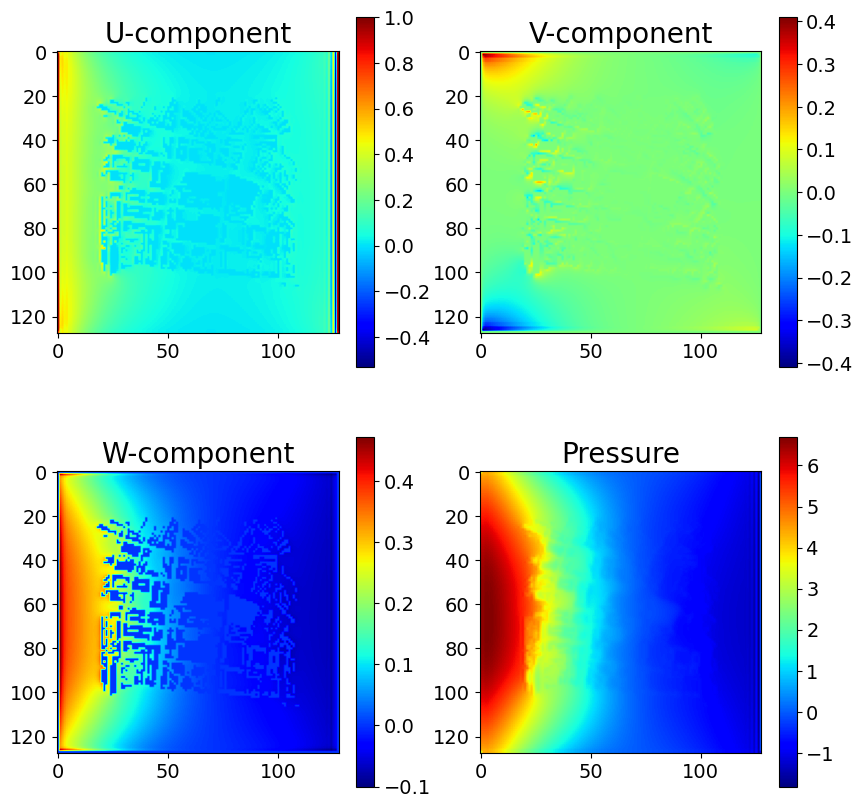

In [676]:
# plot the serial result for 100 timesteps with 10 multi-grid interations for each
serial_result_list = [serial_values_u,serial_values_v,serial_values_w,serial_values_p]
plot_result(serial_result_list,1)

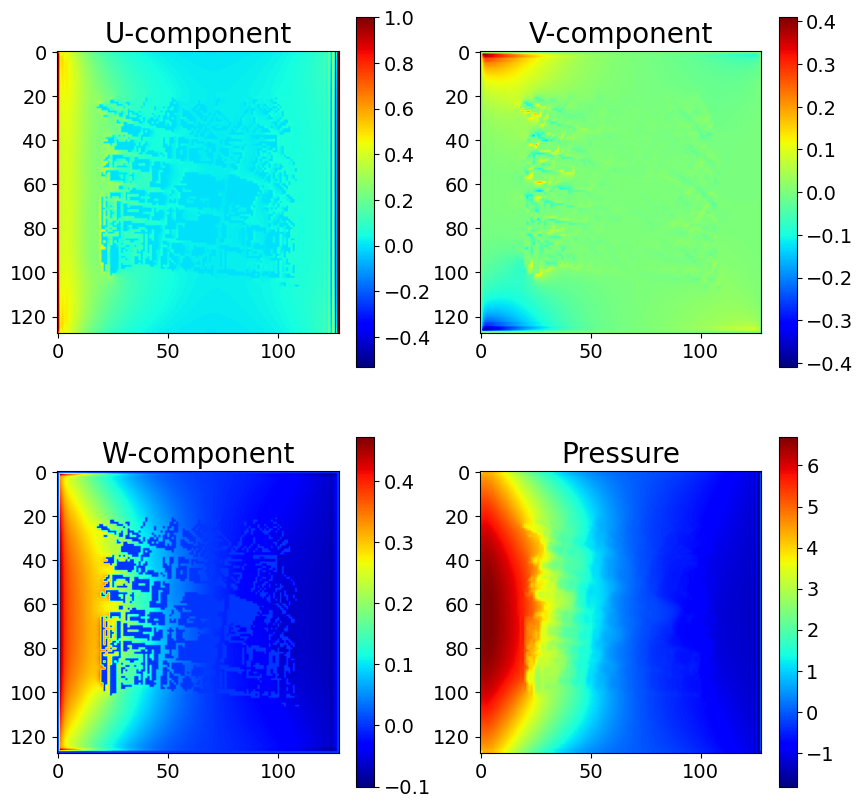

In [677]:
# plot the parallel result
parallel_result_list = [parallel_values_u,parallel_values_v,parallel_values_w,parallel_values_p]
plot_result(parallel_result_list,1)

### Accuracy Error

In [678]:
from numpy import linalg as LA

print("ABEs: ")
print("u:",np.sum(np.abs(serial_values_u - parallel_values_u)))
print("v:",np.sum(np.abs(serial_values_v - parallel_values_v)))
print("w:",np.sum(np.abs(serial_values_w - parallel_values_w)))
print("p:",np.sum(np.abs(serial_values_p - parallel_values_p)))

print("AVG ABEs: ")
print("u:",np.sum(np.abs(serial_values_u - parallel_values_u))/(128*128*128))
print("v:",np.sum(np.abs(serial_values_v - parallel_values_v))/(128*128*128))
print("w:",np.sum(np.abs(serial_values_w - parallel_values_w))/(128*128*128))
print("p:",np.sum(np.abs(serial_values_p - parallel_values_p))/(128*128*128))

print("NORMS: ")
print("SERIAL: ")
print("u:",LA.norm(serial_values_u))
print("v:",LA.norm(serial_values_v))
print("w:",LA.norm(serial_values_w))
print("p:",LA.norm(serial_values_p))
print("PARALLEL: ")
print("u:",LA.norm(parallel_values_u))
print("v:",LA.norm(parallel_values_v))
print("w:",LA.norm(parallel_values_w))
print("p:",LA.norm(parallel_values_p))

print("AVG NORM ABE: ")
avg_norm_abe_u = np.abs(LA.norm(serial_values_u) - LA.norm(parallel_values_u)) / (128*128*128)
avg_norm_abe_v = np.abs(LA.norm(serial_values_v) - LA.norm(parallel_values_v)) / (128*128*128)
avg_norm_abe_w = np.abs(LA.norm(serial_values_w) - LA.norm(parallel_values_w)) / (128*128*128)
avg_norm_abe_p = np.abs(LA.norm(serial_values_p) - LA.norm(parallel_values_p)) / (128*128*128)

print("u:", avg_norm_abe_u)
print("v:", avg_norm_abe_v)
print("w:",avg_norm_abe_w)
print("p:",avg_norm_abe_p)

ABEs: 
u: 0.04792367
v: 0.040812433
w: 0.04338338
p: 0.4612644
AVG ABEs: 
u: 2.2851786241062655e-08
v: 1.94608844594768e-08
w: 2.0686806934122615e-08
p: 2.1994800647462398e-07
NORMS: 
SERIAL: 
u: 359.7567
v: 103.24763
w: 102.2361
p: 5789.2812
PARALLEL: 
u: 359.75674
v: 103.24763
w: 102.2361
p: 5789.2812
AVG NORM ABE: 
u: 1.4551915228366852e-11
v: 0.0
w: 0.0
p: 0.0


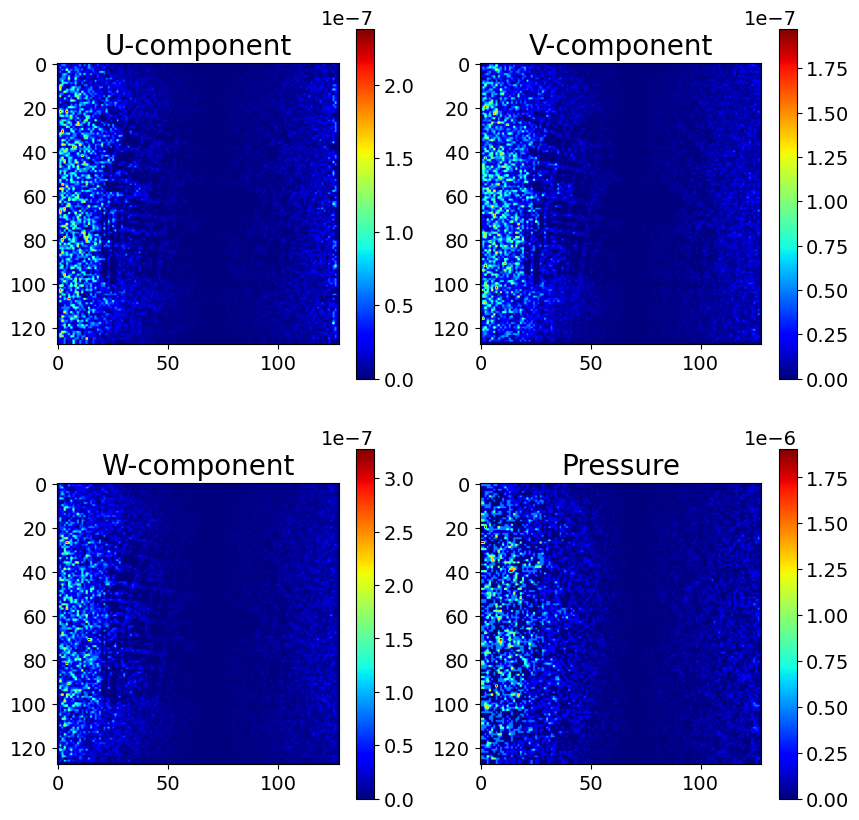

In [679]:
abe_u = np.abs(serial_values_u - parallel_values_u)
abe_v = np.abs(serial_values_v - parallel_values_v)
abe_w = np.abs(serial_values_w - parallel_values_w)
abe_p = np.abs(serial_values_p - parallel_values_p)

abe_list = [abe_u,abe_v,abe_w,abe_p]
plot_result(abe_list,1)

## Accuracy analysis

### Check the result of the Momentum terms

In [382]:
serial_b_u = np.load('boundary_conditions/init_b_w.npy').squeeze()

p_bu_1 = np.load('boundary_conditions/p_init_b_w_0.npy').squeeze()
p_bu_2 = np.load('boundary_conditions/p_init_b_w_1.npy').squeeze()
p_bu_3 = np.load('boundary_conditions/p_init_b_w_2.npy').squeeze()
p_bu_4 = np.load('boundary_conditions/p_init_b_w_3.npy').squeeze()
p_bu_5 = np.load('boundary_conditions/p_init_b_w_4.npy').squeeze()
p_bu_6 = np.load('boundary_conditions/p_init_b_w_5.npy').squeeze()
p_bu_7 = np.load('boundary_conditions/p_init_b_w_6.npy').squeeze()
p_bu_8 = np.load('boundary_conditions/p_init_b_w_7.npy').squeeze()

p_bus = [p_bu_1,p_bu_2,p_bu_3,p_bu_4,p_bu_5,p_bu_6,p_bu_7,p_bu_8]

p_bu = merge_parallel_results_8(p_bus)

# print(serial_b_u.shape,p_bu.shape)

np.sum(np.abs(serial_b_u - p_bu))
# np.where(p_bu != serial_b_u)

0.0

In [383]:
serial_c_u = np.load('boundary_conditions/init_c_w.npy').squeeze()

p_cu_1 = np.load('boundary_conditions/p_init_c_w_0.npy').squeeze()
p_cu_2 = np.load('boundary_conditions/p_init_c_w_1.npy').squeeze()
p_cu_3 = np.load('boundary_conditions/p_init_c_w_2.npy').squeeze()
p_cu_4 = np.load('boundary_conditions/p_init_c_w_3.npy').squeeze()
p_cu_5 = np.load('boundary_conditions/p_init_c_w_4.npy').squeeze()
p_cu_6 = np.load('boundary_conditions/p_init_c_w_5.npy').squeeze()
p_cu_7 = np.load('boundary_conditions/p_init_c_w_6.npy').squeeze()
p_cu_8 = np.load('boundary_conditions/p_init_c_w_7.npy').squeeze()

p_cus = [p_cu_1,p_cu_2,p_cu_3,p_cu_4,p_cu_5,p_cu_6,p_cu_7,p_cu_8]

p_cu = merge_parallel_results_8(p_cus)

# print(serial_c_u.shape,p_cu.shape)

np.sum(np.abs(serial_c_u - p_cu))

0.0

### Check the result of momentum equation

In [346]:
serial_mom_u = np.load("boundary_conditions/mom_val_v.npy").squeeze()

p_mom_u_1 = np.load('boundary_conditions/p_mom_val_v_0.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_mom_u_2 = np.load('boundary_conditions/p_mom_val_v_1.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_mom_u_3 = np.load('boundary_conditions/p_mom_val_v_2.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_mom_u_4 = np.load('boundary_conditions/p_mom_val_v_3.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_mom_u_5 = np.load('boundary_conditions/p_mom_val_v_4.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_mom_u_6 = np.load('boundary_conditions/p_mom_val_v_5.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_mom_u_7 = np.load('boundary_conditions/p_mom_val_v_6.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_mom_u_8 = np.load('boundary_conditions/p_mom_val_v_7.npy')[0,1:-1,1:-1,1:-1,0].squeeze()

p_mom_us = [p_mom_u_1,p_mom_u_2,p_mom_u_3,p_mom_u_4,p_mom_u_5,p_mom_u_6,p_mom_u_7,p_mom_u_8]

p_mom_u = merge_parallel_results_8(p_mom_us)

np.sum(np.abs(serial_mom_u - p_mom_u))

0.0

### Check the result of Immersed Boundary Method 1st

In [347]:
serial_imm_u = np.load("boundary_conditions/imm_val_w.npy").squeeze()

p_imm_u_1 = np.load('boundary_conditions/p_imm_val_w_0.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_imm_u_2 = np.load('boundary_conditions/p_imm_val_w_1.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_imm_u_3 = np.load('boundary_conditions/p_imm_val_w_2.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_imm_u_4 = np.load('boundary_conditions/p_imm_val_w_3.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_imm_u_5 = np.load('boundary_conditions/p_imm_val_w_4.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_imm_u_6 = np.load('boundary_conditions/p_imm_val_w_5.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_imm_u_7 = np.load('boundary_conditions/p_imm_val_w_6.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_imm_u_8 = np.load('boundary_conditions/p_imm_val_w_7.npy')[0,1:-1,1:-1,1:-1,0].squeeze()

p_imm_us = [p_imm_u_1,p_imm_u_2,p_imm_u_3,p_imm_u_4,p_imm_u_5,p_imm_u_6,p_imm_u_7,p_imm_u_8]

p_imm_u = merge_parallel_results_8(p_imm_us)

np.sum(np.abs(serial_imm_u - p_imm_u))

0.0

### Check the result of Pressure gradient method 1st

In [348]:
serial_pg_u = np.load("boundary_conditions/pg_val_w.npy").squeeze()

p_pg_u_1 = np.load('boundary_conditions/p_pg_val_w_0.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg_u_2 = np.load('boundary_conditions/p_pg_val_w_1.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg_u_3 = np.load('boundary_conditions/p_pg_val_w_2.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg_u_4 = np.load('boundary_conditions/p_pg_val_w_3.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg_u_5 = np.load('boundary_conditions/p_pg_val_w_4.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg_u_6 = np.load('boundary_conditions/p_pg_val_w_5.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg_u_7 = np.load('boundary_conditions/p_pg_val_w_6.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg_u_8 = np.load('boundary_conditions/p_pg_val_w_7.npy')[0,1:-1,1:-1,1:-1,0].squeeze()

p_pg_us = [p_pg_u_1,p_pg_u_2,p_pg_u_3,p_pg_u_4,p_pg_u_5,p_pg_u_6,p_pg_u_7,p_pg_u_8]

p_pg_u = merge_parallel_results_8(p_pg_us)

np.sum(np.abs(serial_pg_u - p_pg_u))

0.0

### Check the intermediate coarse grids

#### (2,2,2)

In [645]:
serial_w_2 = np.load("residuals/w_2.npy").squeeze()

p_w_2_1 = np.load("parallel_residuals/p_w_0.npy").reshape(1,1,1)
p_w_2_2 = np.load("parallel_residuals/p_w_1.npy").reshape(1,1,1)
p_w_2_3 = np.load("parallel_residuals/p_w_2.npy").reshape(1,1,1)
p_w_2_4 = np.load("parallel_residuals/p_w_3.npy").reshape(1,1,1)
p_w_2_5 = np.load("parallel_residuals/p_w_4.npy").reshape(1,1,1)
p_w_2_6 = np.load("parallel_residuals/p_w_5.npy").reshape(1,1,1)
p_w_2_7 = np.load("parallel_residuals/p_w_6.npy").reshape(1,1,1)
p_w_2_8 = np.load("parallel_residuals/p_w_7.npy").reshape(1,1,1)

p_w_2s =[p_w_2_1,p_w_2_2,p_w_2_3,p_w_2_4,p_w_2_5,p_w_2_6,p_w_2_7,p_w_2_8]
p_w_2 = merge_parallel_results_8(p_w_2s)

print(serial_w_2)
print(p_w_2)
print(np.abs(serial_w_2 - p_w_2))
print('ABE: ',np.sum(np.abs(serial_w_2) - np.abs(p_w_2)))

[[[-0.04585112  0.02318338]
  [-0.04585112  0.02318338]]

 [[-0.04642122  0.02347333]
  [-0.04642122  0.02347333]]]
[[[-0.04585112  0.02318338]
  [-0.04585112  0.02318338]]

 [[-0.04642122  0.02347333]
  [-0.04642123  0.02347333]]]
[[[7.450581e-09 0.000000e+00]
  [7.450581e-09 0.000000e+00]]

 [[0.000000e+00 0.000000e+00]
  [7.450581e-09 0.000000e+00]]]
ABE:  7.450581e-09


#### (4,4,4)

In [646]:
serial_w_4 = np.load("residuals/w_4.npy").squeeze()

p_w_4_1 = np.load("parallel_residuals/p_w2_0.npy").squeeze()
p_w_4_2 = np.load("parallel_residuals/p_w2_1.npy").squeeze()
p_w_4_3 = np.load("parallel_residuals/p_w2_2.npy").squeeze()
p_w_4_4 = np.load("parallel_residuals/p_w2_3.npy").squeeze()
p_w_4_5 = np.load("parallel_residuals/p_w2_4.npy").squeeze()
p_w_4_6 = np.load("parallel_residuals/p_w2_5.npy").squeeze()
p_w_4_7 = np.load("parallel_residuals/p_w2_6.npy").squeeze()
p_w_4_8 = np.load("parallel_residuals/p_w2_7.npy").squeeze()

p_w_4s =[p_w_4_1,p_w_4_2,p_w_4_3,p_w_4_4,p_w_4_5,p_w_4_6,p_w_4_7,p_w_4_8]
p_w_4 = merge_parallel_results_8(p_w_4s)

# print(serial_w_4)
# print(p_w_4)
# print(np.abs(serial_w_4 - p_w_4))
print('ABE: ',np.sum(np.abs(serial_w_4) - np.abs(p_w_4)))


ABE:  4.656613e-08


#### (8,8,8)

In [647]:
serial_w_8 = np.load("residuals/w_8.npy").squeeze()

p_w_8_1 = np.load("parallel_residuals/p_w4_0.npy").squeeze()
p_w_8_2 = np.load("parallel_residuals/p_w4_1.npy").squeeze()
p_w_8_3 = np.load("parallel_residuals/p_w4_2.npy").squeeze()
p_w_8_4 = np.load("parallel_residuals/p_w4_3.npy").squeeze()
p_w_8_5 = np.load("parallel_residuals/p_w4_4.npy").squeeze()
p_w_8_6 = np.load("parallel_residuals/p_w4_5.npy").squeeze()
p_w_8_7 = np.load("parallel_residuals/p_w4_6.npy").squeeze()
p_w_8_8 = np.load("parallel_residuals/p_w4_7.npy").squeeze()

p_w_8s =[p_w_8_1,p_w_8_2,p_w_8_3,p_w_8_4,p_w_8_5,p_w_8_6,p_w_8_7,p_w_8_8]
p_w_8 = merge_parallel_results_8(p_w_8s)

# print(serial_w_4)
# print(p_w_4)
# print(np.abs(serial_w_4 - p_w_4))
print('ABE: ',np.sum(np.abs(serial_w_8) - np.abs(p_w_8)))

ABE:  3.091991e-07


#### (16,16,16)

In [648]:
serial_w_16 = np.load("residuals/w_16.npy").squeeze()

p_w_16_1 = np.load("parallel_residuals/p_w8_0.npy").squeeze()
p_w_16_2 = np.load("parallel_residuals/p_w8_1.npy").squeeze()
p_w_16_3 = np.load("parallel_residuals/p_w8_2.npy").squeeze()
p_w_16_4 = np.load("parallel_residuals/p_w8_3.npy").squeeze()
p_w_16_5 = np.load("parallel_residuals/p_w8_4.npy").squeeze()
p_w_16_6 = np.load("parallel_residuals/p_w8_5.npy").squeeze()
p_w_16_7 = np.load("parallel_residuals/p_w8_6.npy").squeeze()
p_w_16_8 = np.load("parallel_residuals/p_w8_7.npy").squeeze()

p_w_16s =[p_w_16_1,p_w_16_2,p_w_16_3,p_w_16_4,p_w_16_5,p_w_16_6,p_w_16_7,p_w_16_8]
p_w_16 = merge_parallel_results_8(p_w_16s)

# print(serial_w_4)
# print(p_w_4)
# print(np.abs(serial_w_4 - p_w_4))
print('ABE: ',np.sum(np.abs(serial_w_16) -np.abs(p_w_16)))

ABE:  2.0596199e-06


#### (32,32,32)

In [649]:
serial_w_32 = np.load("residuals/w_32.npy").squeeze()

p_w_32_1 = np.load("parallel_residuals/p_w16_0.npy").squeeze()
p_w_32_2 = np.load("parallel_residuals/p_w16_1.npy").squeeze()
p_w_32_3 = np.load("parallel_residuals/p_w16_2.npy").squeeze()
p_w_32_4 = np.load("parallel_residuals/p_w16_3.npy").squeeze()
p_w_32_5 = np.load("parallel_residuals/p_w16_4.npy").squeeze()
p_w_32_6 = np.load("parallel_residuals/p_w16_5.npy").squeeze()
p_w_32_7 = np.load("parallel_residuals/p_w16_6.npy").squeeze()
p_w_32_8 = np.load("parallel_residuals/p_w16_7.npy").squeeze()

p_w_32s =[p_w_32_1,p_w_32_2,p_w_32_3,p_w_32_4,p_w_32_5,p_w_32_6,p_w_32_7,p_w_32_8]
p_w_32 = merge_parallel_results_8(p_w_32s)

# print(serial_w_4)
# print(p_w_4)
# print(np.abs(serial_w_32 - p_w_32))
print('ABE: ',np.sum(np.abs(serial_w_32) - np.abs(p_w_32)))

ABE:  1.754699e-05


#### (64,64,64)

In [650]:
serial_w_64 = np.load("residuals/w_64.npy").squeeze()

p_w_64_1 = np.load("parallel_residuals/p_w32_0.npy").squeeze()
p_w_64_2 = np.load("parallel_residuals/p_w32_1.npy").squeeze()
p_w_64_3 = np.load("parallel_residuals/p_w32_2.npy").squeeze()
p_w_64_4 = np.load("parallel_residuals/p_w32_3.npy").squeeze()
p_w_64_5 = np.load("parallel_residuals/p_w32_4.npy").squeeze()
p_w_64_6 = np.load("parallel_residuals/p_w32_5.npy").squeeze()
p_w_64_7 = np.load("parallel_residuals/p_w32_6.npy").squeeze()
p_w_64_8 = np.load("parallel_residuals/p_w32_7.npy").squeeze()


p_w_64s =[p_w_64_1,p_w_64_2,p_w_64_3,p_w_64_4,p_w_64_5,p_w_64_6,p_w_64_7,p_w_64_8]
p_w_64 = merge_parallel_results_8(p_w_64s)

# print(serial_w_4)
# print(p_w_4)
# print(np.abs(serial_w_4 - p_w_4))
print('ABE: ',np.sum(np.abs(serial_w_64) - np.abs(p_w_64)))

ABE:  0.00013843576


#### (128,128,128)

In [651]:
serial_w_128 = np.load("residuals/w_128.npy").squeeze()

p_w_128_1 = np.load("parallel_residuals/p_w64_0.npy").squeeze()
p_w_128_2 = np.load("parallel_residuals/p_w64_1.npy").squeeze()
p_w_128_3 = np.load("parallel_residuals/p_w64_2.npy").squeeze()
p_w_128_4 = np.load("parallel_residuals/p_w64_3.npy").squeeze()
p_w_128_5 = np.load("parallel_residuals/p_w64_4.npy").squeeze()
p_w_128_6 = np.load("parallel_residuals/p_w64_5.npy").squeeze()
p_w_128_7 = np.load("parallel_residuals/p_w64_6.npy").squeeze()
p_w_128_8 = np.load("parallel_residuals/p_w64_7.npy").squeeze()


p_w_128s =[p_w_128_1,p_w_128_2,p_w_128_3,p_w_128_4,p_w_128_5,p_w_128_6,p_w_128_7,p_w_128_8]
p_w_128 = merge_parallel_results_8(p_w_128s)

# print(serial_w_128)
# print(p_w_128)
# print(np.abs(serial_w_128 - p_w_128))
print('ABE: ',np.sum(np.abs(serial_w_128) - np.abs(p_w_128))) #? why is this getting enormous?
# print(np.sum(serial_w_128))
# print(np.sum(p_w_128))

ABE:  0.0011138698


### Check the result of Multi-grid method

In [680]:
serial_mult_p = np.load("boundary_conditions/multgrid_p.npy").squeeze()

# p_mult_p_1 = np.load('boundary_conditions/p_multigrid_p_0.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
# p_mult_p_2 = np.load('boundary_conditions/p_multigrid_p_1.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
# p_mult_p_3 = np.load('boundary_conditions/p_multigrid_p_2.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
# p_mult_p_4 = np.load('boundary_conditions/p_multigrid_p_3.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
# p_mult_p_5 = np.load('boundary_conditions/p_multigrid_p_4.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
# p_mult_p_6 = np.load('boundary_conditions/p_multigrid_p_5.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
# p_mult_p_7 = np.load('boundary_conditions/p_multigrid_p_6.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
# p_mult_p_8 = np.load('boundary_conditions/p_multigrid_p_7.npy')[0,1:-1,1:-1,1:-1,0].squeeze()

p_mult_p_1 = np.load('boundary_conditions/p_multigrid_p_0.npy').squeeze()
p_mult_p_2 = np.load('boundary_conditions/p_multigrid_p_1.npy').squeeze()
p_mult_p_3 = np.load('boundary_conditions/p_multigrid_p_2.npy').squeeze()
p_mult_p_4 = np.load('boundary_conditions/p_multigrid_p_3.npy').squeeze()
p_mult_p_5 = np.load('boundary_conditions/p_multigrid_p_4.npy').squeeze()
p_mult_p_6 = np.load('boundary_conditions/p_multigrid_p_5.npy').squeeze()
p_mult_p_7 = np.load('boundary_conditions/p_multigrid_p_6.npy').squeeze()
p_mult_p_8 = np.load('boundary_conditions/p_multigrid_p_7.npy').squeeze()

p_mult_ps = [p_mult_p_1,p_mult_p_2,p_mult_p_3,p_mult_p_4,p_mult_p_5,p_mult_p_6,p_mult_p_7,p_mult_p_8]

p_mult_p = merge_parallel_results_8(p_mult_ps)

print(serial_mult_p.shape,p_mult_p.shape)


np.sum(np.abs(serial_mult_p) - np.abs(p_mult_p))

(128, 128, 128) (128, 128, 128)


0.0011066676

### Check the result of Pressure gradient method 2nd

In [653]:
serial_pg1_u = np.load("boundary_conditions/pg1_val_p.npy").squeeze()

p_pg1_u_1 = np.load('boundary_conditions/p_pg1_val_p_0.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg1_u_2 = np.load('boundary_conditions/p_pg1_val_p_1.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg1_u_3 = np.load('boundary_conditions/p_pg1_val_p_2.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg1_u_4 = np.load('boundary_conditions/p_pg1_val_p_3.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg1_u_5 = np.load('boundary_conditions/p_pg1_val_p_4.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg1_u_6 = np.load('boundary_conditions/p_pg1_val_p_5.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg1_u_7 = np.load('boundary_conditions/p_pg1_val_p_6.npy')[0,1:-1,1:-1,1:-1,0].squeeze()
p_pg1_u_8 = np.load('boundary_conditions/p_pg1_val_p_7.npy')[0,1:-1,1:-1,1:-1,0].squeeze()

p_pg1_us = [p_pg1_u_1,p_pg1_u_2,p_pg1_u_3,p_pg1_u_4,p_pg1_u_5,p_pg1_u_6,p_pg1_u_7,p_pg1_u_8]

p_pg1_u = merge_parallel_results_8(p_pg1_us)

np.sum(np.abs(serial_pg1_u - p_pg1_u))

0.0025641718

### Check the initial Possion Equation result

In [654]:
serial_b = np.load('boundary_conditions/init_b.npy').squeeze()

p_b_1 = np.load('boundary_conditions/parallel_init_b_0.npy').squeeze()
p_b_2  = np.load('boundary_conditions/parallel_init_b_1.npy').squeeze()
p_b_3  = np.load('boundary_conditions/parallel_init_b_2.npy').squeeze()
p_b_4  = np.load('boundary_conditions/parallel_init_b_3.npy').squeeze()
p_b_5  = np.load('boundary_conditions/parallel_init_b_4.npy').squeeze()
p_b_6  = np.load('boundary_conditions/parallel_init_b_5.npy').squeeze()
p_b_7  = np.load('boundary_conditions/parallel_init_b_6.npy').squeeze()
p_b_8  = np.load('boundary_conditions/parallel_init_b_7.npy').squeeze()

p_bs = [p_b_1,p_b_2,p_b_3,p_b_4,p_b_5,p_b_6,p_b_7,p_b_8]

p_b = merge_parallel_results_8(p_bs)

np.sum(np.abs(serial_b - p_b))


0.0

### Check Initial Residual

In [655]:
from numpy import linalg as LA

serial_res = np.load('residuals/naiver_stokes_res.npy').squeeze()

p_res_1 = np.load('parallel_residuals/parallel_naiver_stokes_res_0.npy').squeeze()
p_res_2 = np.load('parallel_residuals/parallel_naiver_stokes_res_1.npy').squeeze()
p_res_3 = np.load('parallel_residuals/parallel_naiver_stokes_res_2.npy').squeeze()
p_res_4 = np.load('parallel_residuals/parallel_naiver_stokes_res_3.npy').squeeze()
p_res_5 = np.load('parallel_residuals/parallel_naiver_stokes_res_4.npy').squeeze()
p_res_6 = np.load('parallel_residuals/parallel_naiver_stokes_res_5.npy').squeeze()
p_res_7 = np.load('parallel_residuals/parallel_naiver_stokes_res_6.npy').squeeze()
p_res_8 = np.load('parallel_residuals/parallel_naiver_stokes_res_7.npy').squeeze()

p_residuals = [p_res_1,p_res_2,p_res_3,p_res_4,p_res_5,p_res_6,p_res_7,p_res_8]

p_res = merge_parallel_results_8(p_residuals)

np.sum(np.abs(serial_res - p_res))

0.0

In [656]:
np.where(serial_res != p_res)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

### Check the initial boundary conditions

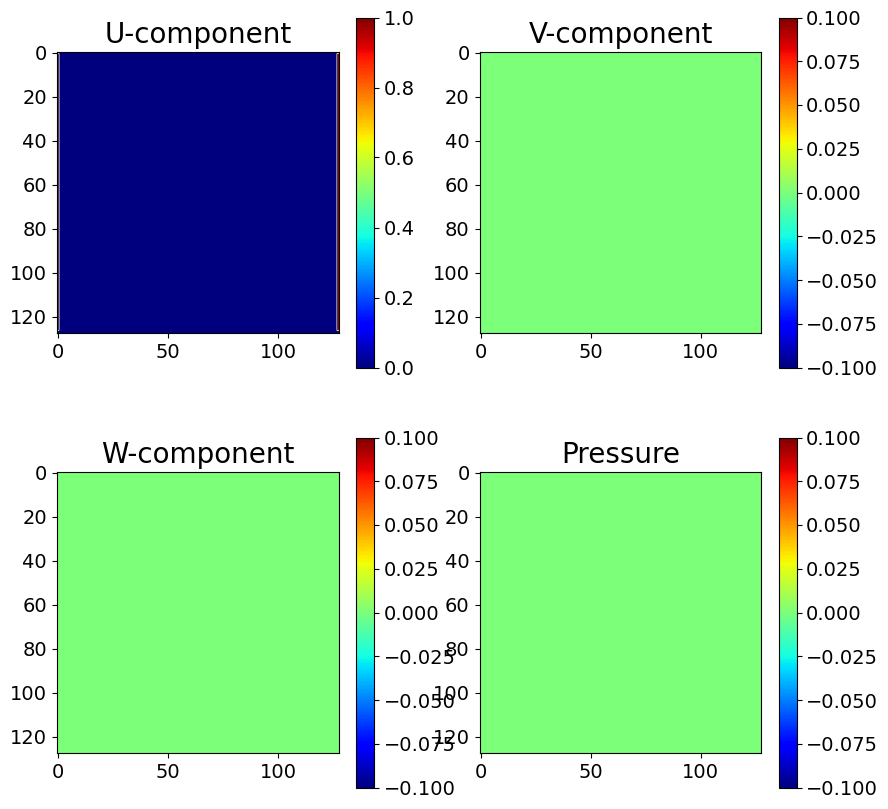

In [657]:
serial_bc_u = np.load('boundary_conditions/init_val_u.npy').squeeze()
serial_bc_v = np.load('boundary_conditions/init_val_v.npy').squeeze()
serial_bc_w = np.load('boundary_conditions/init_val_w.npy').squeeze()
serial_bc_p = np.load('boundary_conditions/init_val_p.npy').squeeze()

serial_bc_list = [serial_bc_u,serial_bc_v,serial_bc_w,serial_bc_p]
plot_result(serial_bc_list,1)

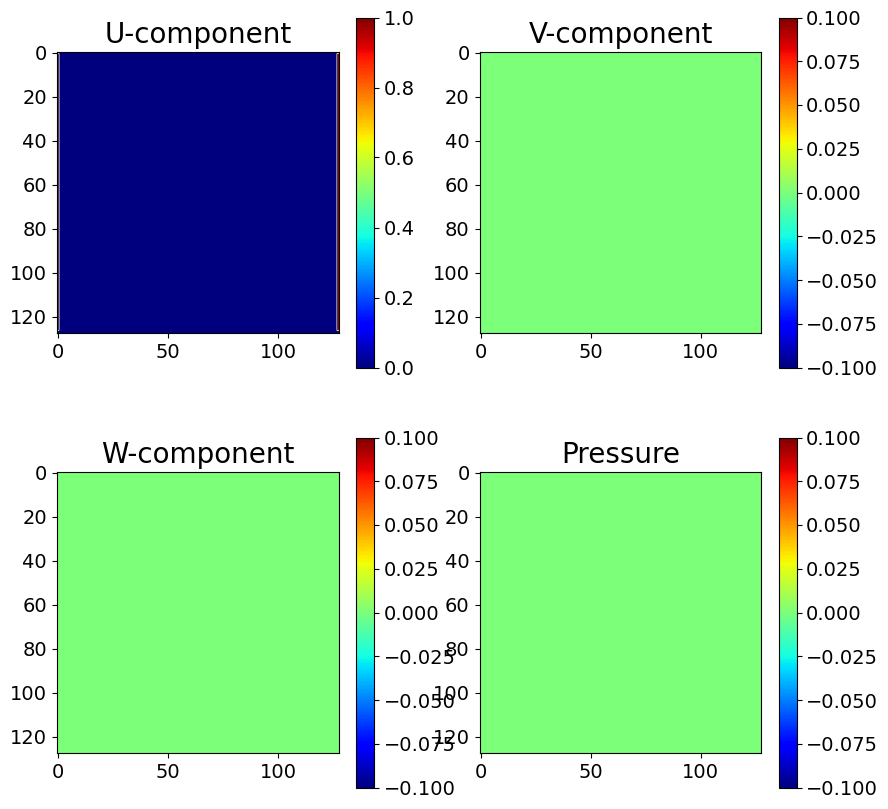

In [658]:
def load_parallel_bc(item_name,proc_nums):
    parallel_results = []
    for i in range(proc_nums):
        temp_subdomain = np.load("boundary_conditions/init_p_val_{}_{}.npy".format(item_name,i))
        temp_subdomain = temp_subdomain[0,1:-1,1:-1,1:-1,0]
        parallel_results.append(temp_subdomain)
    
    return parallel_results

parallel_u_bcs = load_parallel_bc('u',8)
parallel_v_bcs = load_parallel_bc('v',8)
parallel_w_bcs = load_parallel_bc('w',8)
parallel_p_bcs = load_parallel_bc('p',8)

parallel_u_bc = merge_parallel_results_8(parallel_u_bcs)
parallel_v_bc = merge_parallel_results_8(parallel_v_bcs)
parallel_w_bc = merge_parallel_results_8(parallel_w_bcs)
parallel_p_bc = merge_parallel_results_8(parallel_p_bcs)

parallel_bc_list = [parallel_u_bc,parallel_v_bc,parallel_w_bc,parallel_p_bc]
plot_result(parallel_bc_list,1)

In [659]:
# abe of the initial boundary conditions
print(np.sum(np.abs(serial_bc_u - parallel_u_bc)))
print(np.sum(np.abs(serial_bc_v - parallel_v_bc)))
print(np.sum(np.abs(serial_bc_w - parallel_w_bc)))
print(np.sum(np.abs(serial_bc_p - parallel_p_bc)))

0.0
0.0
0.0
0.0


(128, 128, 128)


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

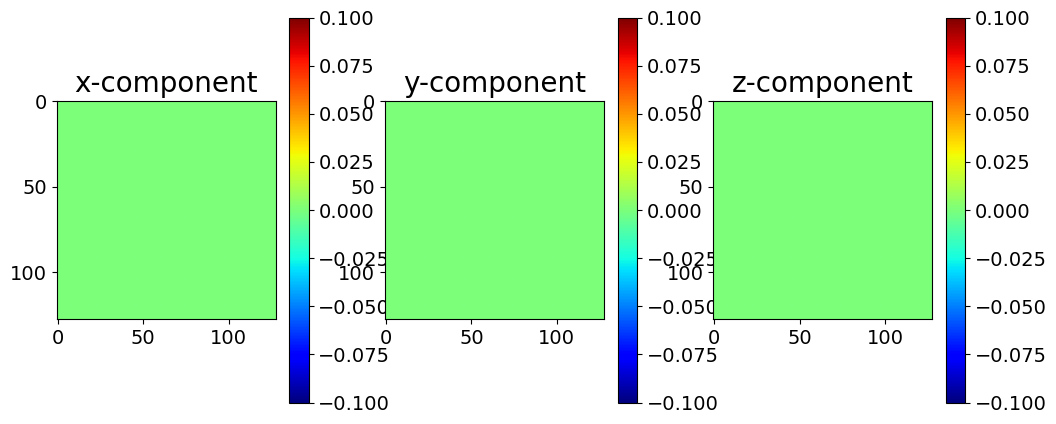

In [660]:
err = np.abs(serial_bc_u - parallel_u_bc)
print(err.shape)

fig, axs = plt.subplots(2, 2, figsize=(12, 5))
plt.subplot(1,3,1)
plt.imshow(err[:,0,:], cmap='jet')
plt.colorbar()
plt.title('x-component',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(err[:,:,0], cmap='jet')
plt.colorbar()
plt.title('y-component',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(err[0,:,:], cmap='jet')
plt.colorbar()
plt.title('z-component',fontsize=20)

np.where(err != 0)

In [661]:
from numpy import linalg as LA

print("NORMS: ")
print("SERIAL: ")
print("u:",LA.norm(serial_bc_u))
print("v:",LA.norm(serial_bc_v))
print("w:",LA.norm(serial_bc_w))
print("p:",LA.norm(serial_bc_p))
print("PARALLEL: ")
print("u:",LA.norm(parallel_u_bc))
print("v:",LA.norm(parallel_v_bc))
print("w:",LA.norm(parallel_w_bc))
print("p:",LA.norm(parallel_p_bc))


print("AVG NORM ABE: ")
avg_norm_abe_u = np.abs(LA.norm(serial_bc_u) - LA.norm(parallel_u_bc)) / (128*128*128)
avg_norm_abe_v = np.abs(LA.norm(serial_bc_v) - LA.norm(parallel_v_bc)) / (128*128*128)
avg_norm_abe_w = np.abs(LA.norm(serial_bc_w) - LA.norm(parallel_w_bc)) / (128*128*128)
avg_norm_abe_p = np.abs(LA.norm(serial_bc_p) - LA.norm(parallel_p_bc)) / (128*128*128)

print("u:", avg_norm_abe_u)
print("v:", avg_norm_abe_v)
print("w:",avg_norm_abe_w)
print("p:",avg_norm_abe_p)

NORMS: 
SERIAL: 
u: 178.1909
v: 0.0
w: 0.0
p: 0.0
PARALLEL: 
u: 178.1909
v: 0.0
w: 0.0
p: 0.0
AVG NORM ABE: 
u: 0.0
v: 0.0
w: 0.0
p: 0.0
